Below business model provide the insights about the value
depreciation pattern of cars which depends on various usage pattern (Year of purchase, Last numbers of owner, travel distance in Kilometres) with respect to its features (Fuel type, Transmission Drive, Segment).
For a automobile dealer company, this model will forecast a higher transaction rate while dealing with categories:
1. Fuel type with segment of automobile.
2. Transmission type with segment of automobile.

#Data Pre-processing

In [1]:
#import all libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
#import dataset
cars_resale = pd.read_csv('/content/cars_24_combined.csv')

In [ ]:
#print first 5 rows of dataset
cars_resale.head()

Unnamed: 0              Car Name    Year  Distance  Owner    Fuel Location  \
0           0       Maruti S PRESSO  2022.0      3878      1  PETROL    HR-98   
1           1         Hyundai Xcent  2018.0     32041      1  PETROL    TN-22   
2           2           Tata Safari  2021.0     96339      1  DIESEL    TS-08   
3           3  Maruti Vitara Brezza  2019.0     51718      1  DIESEL    WB-24   
4           4            Tata Tiago  2021.0     19811      1  PETROL    HR-51   

       Drive       Type    Price  
0     Manual  HatchBack   514000  
1     Manual      Sedan   674000  
2  Automatic        SUV  1952000  
3     Manual        SUV   690000  
4     Manual  HatchBack   526000

In dataset 'cars_resale' there are 10 attributes being 'Price' column as observed price when resold as per other parameters.

In [ ]:
#describe columns with numerical data
cars_resale.describe()

Unnamed: 0         Year       Distance        Owner         Price
count  8015.000000  8014.000000    8015.000000  8015.000000  8.015000e+03
mean   4007.000000  2016.995009   52621.411728     1.300187  5.748829e+05
std    2313.875537     2.861454   29182.922728     0.510893  2.651049e+05
min       0.000000  2010.000000       0.000000     1.000000  1.190000e+05
25%    2003.500000  2015.000000   30730.000000     1.000000  3.930000e+05
50%    4007.000000  2017.000000   50359.000000     1.000000  5.350000e+05
75%    6010.500000  2019.000000   71762.000000     2.000000  6.980000e+05
max    8014.000000  2023.000000  971212.000000     4.000000  3.300000e+06

Describing attributes showcase, there are 8015 count of cars resold data that were purchase in range of year 2010-2023, range of distance travelled 0-971212 Kms and maximum of 4 last owners. Price variation of 1.19e+5 to 3.3e+6 depicts the range of 100 thousand to 3 million units of currency.

In [ ]:
#information about all columns
cars_resale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8015 entries, 0 to 8014
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8015 non-null   int64  
 1   Car Name    8014 non-null   object 
 2   Year        8014 non-null   float64
 3   Distance    8015 non-null   int64  
 4   Owner       8015 non-null   int64  
 5   Fuel        8015 non-null   object 
 6   Location    7802 non-null   object 
 7   Drive       8015 non-null   object 
 8   Type        8015 non-null   object 
 9   Price       8015 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 626.3+ KB


5 attributes with object (combination of text and numericals) type best describe the category of the cars and 4 attributes with int64(numbers) and 1 attribute 'Year' as float64 to support numerical with decimal entries.

In [ ]:
#get sum of all null values
cars_resale.isnull().sum()

Unnamed: 0      0
Car Name        1
Year            1
Distance        0
Owner           0
Fuel            0
Location      213
Drive           0
Type            0
Price           0
dtype: int64

2 columns have only 1 null values but column 'Location' has 213 null values need to handle to increase the accuracy of predictive price.

In [ ]:
#percentage of missing values
missing_percentage = cars_resale.isnull().sum() / len(cars_resale) * 100
print(missing_percentage)

Unnamed: 0    0.000000
Car Name      0.012477
Year          0.012477
Distance      0.000000
Owner         0.000000
Fuel          0.000000
Location      2.657517
Drive         0.000000
Type          0.000000
Price         0.000000
dtype: float64


It is possible to drop less than 5% of data rows as it is very small proportion of data.

In [3]:
#drop null value rows
cars_resale = cars_resale.dropna(subset=['Car Name', 'Year', 'Location'])

#recheck missing Percentage
missing_percentage = cars_resale.isnull().sum() / len(cars_resale) * 100
print(missing_percentage)

Unnamed: 0    0.0
Car Name      0.0
Year          0.0
Distance      0.0
Owner         0.0
Fuel          0.0
Location      0.0
Drive         0.0
Type          0.0
Price         0.0
dtype: float64


Dataset need to have 0 null values to train and test the predictive type model.

In [4]:
#drop extra columns
cars_resale = cars_resale.drop(columns=['Unnamed: 0'])

'Unnamed : 0' is ID column that might be added for identity of rows.

In [ ]:
#check of unique values
cars_resale['Year'].unique()

array([2022., 2018., 2021., 2019., 2017., 2015., 2012., 2016., 2010.,
       2011., 2013., 2014., 2020., 2023.])

In [5]:
#replace year column, subtraction of current year from the year
cars_resale['Year'] = 2024 - cars_resale['Year']

This decrease the value of numerical column, also showcase more relevance when describe in year usage.

In [ ]:
#check unique values to assign ordinal function as years must be in order of count
cars_resale['Year'].unique()

array([ 2.,  6.,  3.,  5.,  7.,  9., 12.,  8., 14., 13., 11., 10.,  4.,
        1.])

Usage of cars in years varies from 1-14

In [ ]:
#unique values in last owners assigned ordinal feature.
cars_resale['Owner'].unique()

array([1, 2, 3, 4])

There are maximum 4 owners cars available in dataset

In [6]:
#convert Regional Transport district to states as stated by initials (e.g. HR-01 = HR, MH-01 = MH, KA-09 = KA)
cars_resale["Location"] = cars_resale["Location"].str.slice(0, 2)

#unique values in Location Column
cars_resale['Location'].unique().tolist()

['HR',
 'TN',
 'TS',
 'WB',
 'MH',
 'UP',
 'KA',
 'PB',
 'GJ',
 'DL',
 'CH',
 'KL',
 'RJ',
 'BR',
 'AP',
 'MP',
 '22']

#Exploratory Data Analysis

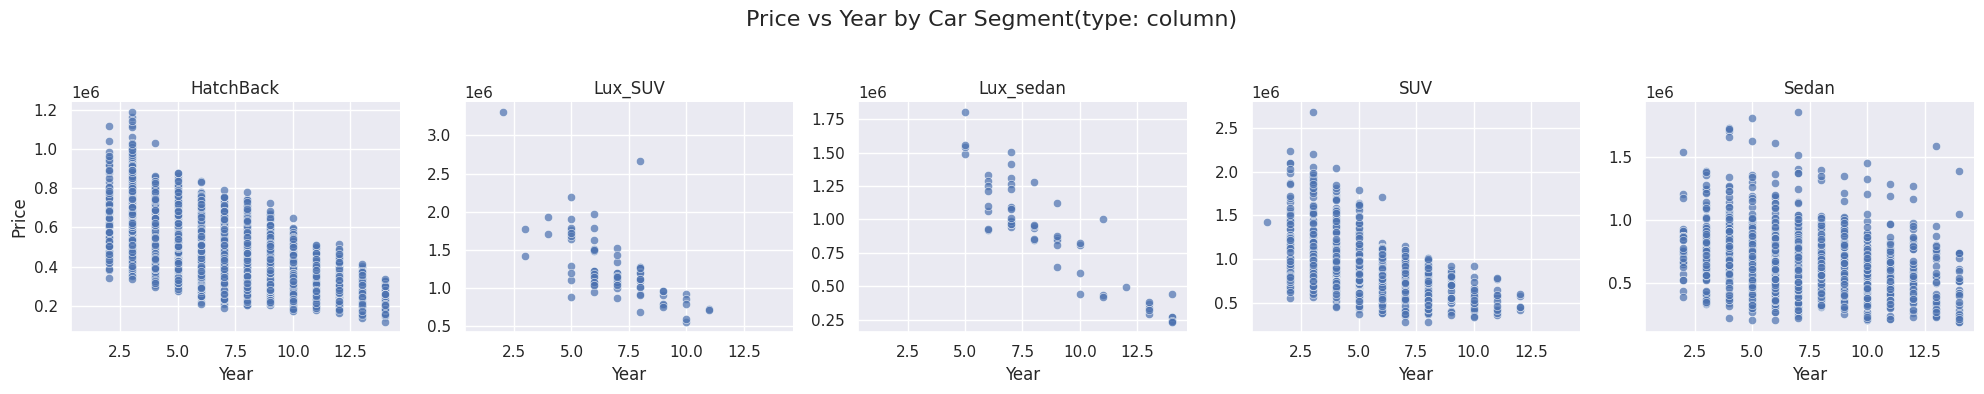

In [ ]:
#plot facetGrid: Price vs Year for each Type
cars_resale['Type'] = cars_resale['Type'].astype('category')


g = sns.FacetGrid(cars_resale, col="Type", col_wrap=5, height=4, sharey=False)
g.map(sns.scatterplot, "Year", "Price", alpha=0.7)

# Add titles and adjust layout
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Price")
plt.subplots_adjust(top=0.75)
g.fig.suptitle("Price vs Year by Car Segment(type: column)", fontsize=16)
plt.show()

No perfect relation with usage cars in years with price can be seen in particular variant.

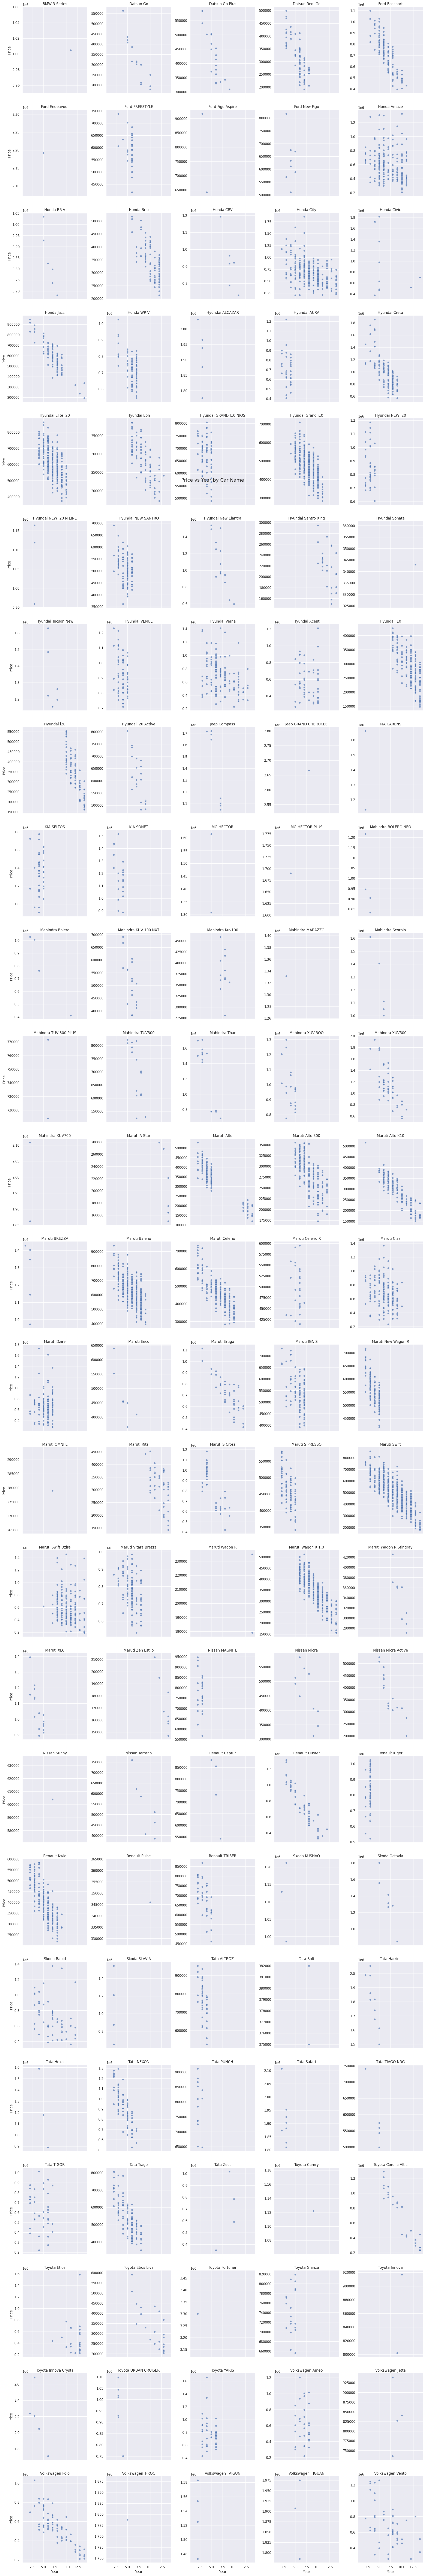

In [ ]:
#plot facetGrid: Price vs Year for each Car Name
cars_resale['Car Name'] = cars_resale['Car Name'].astype('category')


g = sns.FacetGrid(cars_resale, col="Car Name", col_wrap=5, height=4, sharey=False)
g.map(sns.scatterplot, "Year", "Price", alpha=0.7)

#add titles and adjust layout
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Price")
plt.subplots_adjust(top=1.2)
g.fig.suptitle("Price vs Year by Car Name", fontsize=16)
plt.show()

We can find a relation here but still there are same price values for newer cars. But we can delete some car entries, as it might cause error in our prediction model.

In [ ]:
cars_resale.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7607 entries, 0 to 8014
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Car Name  7607 non-null   category
 1   Year      7607 non-null   float64 
 2   Distance  7607 non-null   int64   
 3   Owner     7607 non-null   int64   
 4   Fuel      7607 non-null   object  
 5   Location  7607 non-null   object  
 6   Drive     7607 non-null   object  
 7   Type      7607 non-null   category
 8   Price     7607 non-null   int64   
dtypes: category(2), float64(1), int64(3), object(3)
memory usage: 495.5+ KB


<ipython-input-124-62c685239497>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars_resale['Car Name'] = cars_resale['Car Name'].astype('category')


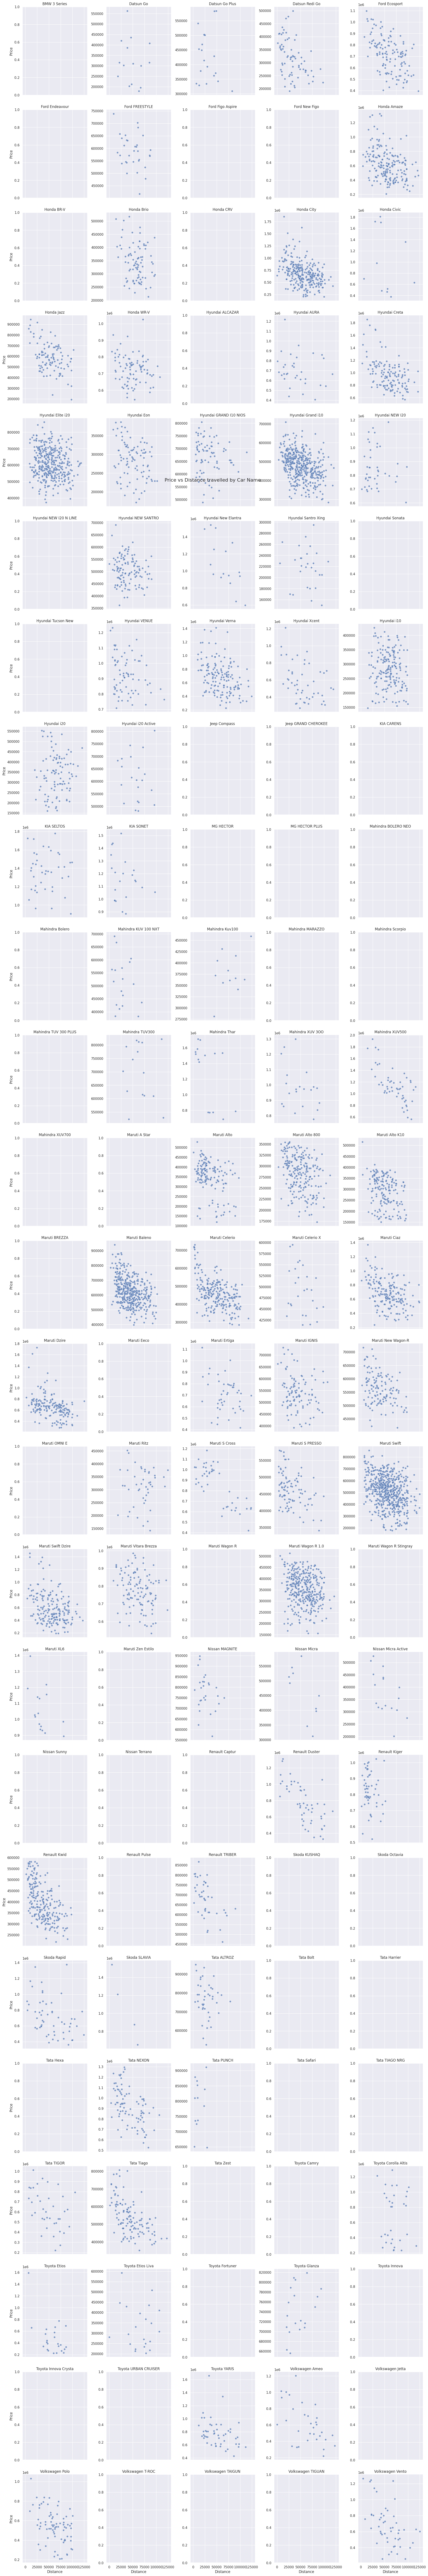

In [ ]:
#plot facetGrid: Price vs Distance travelled for each Car Name
cars_resale['Car Name'] = cars_resale['Car Name'].astype('category')


g = sns.FacetGrid(cars_resale, col="Car Name", col_wrap=5, height=4, sharey=False)
g.map(sns.scatterplot, "Distance", "Price", alpha=0.7)

#add titles and adjust layout
g.set_titles("{col_name}")
g.set_axis_labels("Distance", "Price")
plt.subplots_adjust(top=1.2)
g.fig.suptitle("Price vs Distance travelled by Car Name", fontsize=16)
plt.show()

No Car Name enteries are outliers so that we can obtain precision in our model.

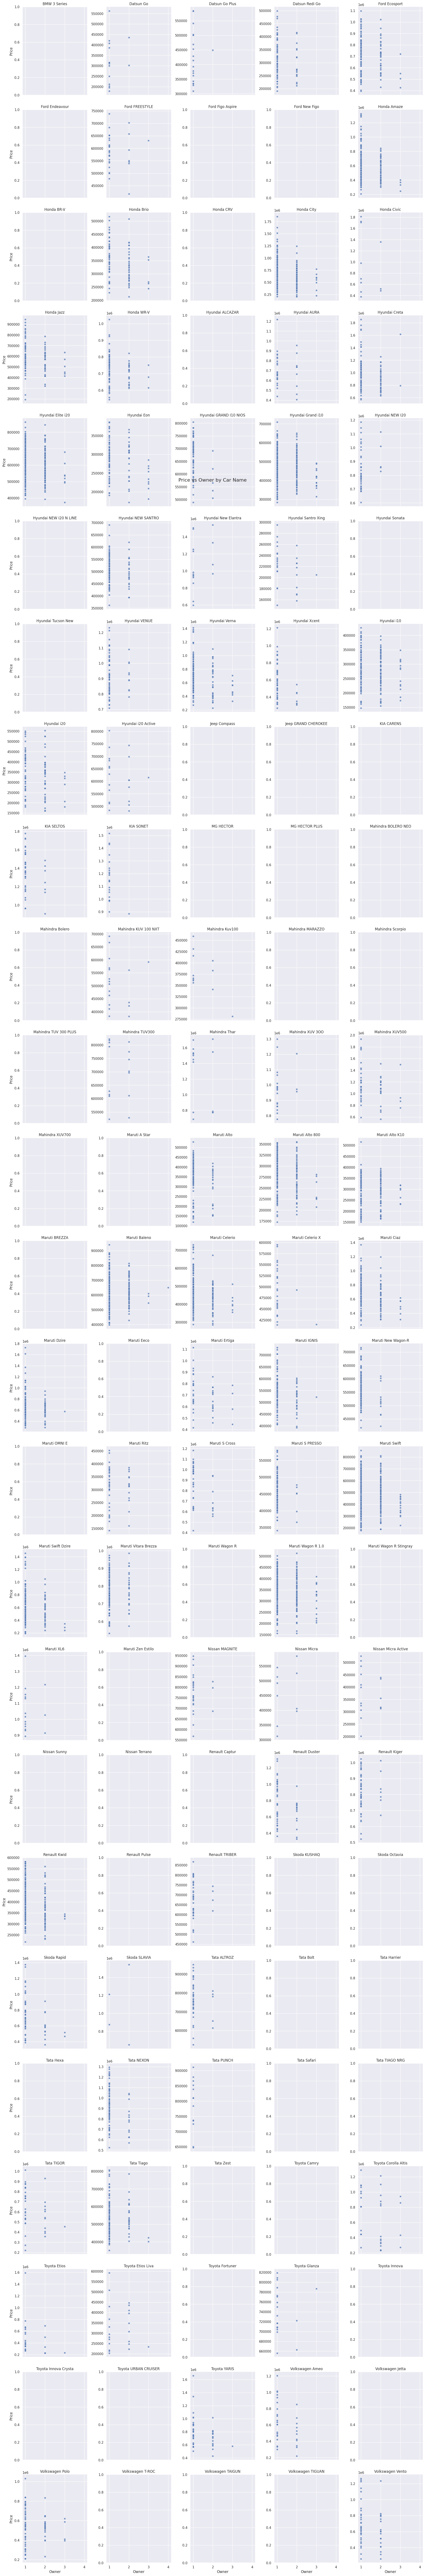

In [ ]:
#plot facetGrid: Price vs Owner for each Car Name
cars_resale['Car Name'] = cars_resale['Car Name'].astype('category')


g = sns.FacetGrid(cars_resale, col="Car Name", col_wrap=5, height=4, sharey=False)
g.map(sns.scatterplot, "Owner", "Price", alpha=0.7)

#add titles and adjust layout
g.set_titles("{col_name}")
g.set_axis_labels("Owner", "Price")
plt.subplots_adjust(top=1.2)
g.fig.suptitle("Price vs Owner by Car Name", fontsize=16)
plt.show()

In [7]:
car_names_to_delete = [
    "BMW 3 Series", "Ford Endeavour", "Ford Figo Aspire", "Ford New Figo", "Honda BR-V", "Honda CRV",
    "Hyundai ALCAZAR", "Hyundai NEW I20 N LINE", "Hyundai Sonata", "Hyundai Tucson New",
    "Jeep Compass", "Jeep GRAND CHEROKEE", "KIA CARENS", "MG HECTOR", "MG HECTOR PLUS",
    "Mahindra BOLERO NEO", "Mahindra Bolero", "Mahindra MARAZZO", "Mahindra Scorpio",
    "Mahindra TUV 300 PLUS", "Mahindra XUV700", "Maruti A Star", "Maruti BREZZA", "Maruti Eeco",
    "Maruti OMNI E", "Maruti Wagon R", "Maruti Wagon R Stingray", "Maruti Zen Estilo",
    "Nissan Sunny", "Nissan Terrano", "Renault Captur", "Renault Pulse", "Skoda KUSHAQ",
    "Skoda Octavia", "Skode SLAVIA", "Tata Bolt", "Tata Harrier", "Tata Hexa", "Tata Safari",
    "Tata TIAGO NRG", "Tata Zest", "Toyota Camry", "Toyota Fortuner", "Toyota Innova",
    "Toyota Innova Crysta", "Toyota URBAN CRUISER", "Volkswagen Jetta", "Volkswagen T-ROC",
    "Volkswagen TAIGUN", "Volkswagen TIGUAN"
]

#remove rows where 'Car Name' matches any in the list
cars_resale = cars_resale[~cars_resale["Car Name"].isin(car_names_to_delete)]

So, we need all the numerical features Year, distance, owners to predict resale price. Also catergorial variables need to be map as numericals to make a correlation to our target attribute 'Price'.

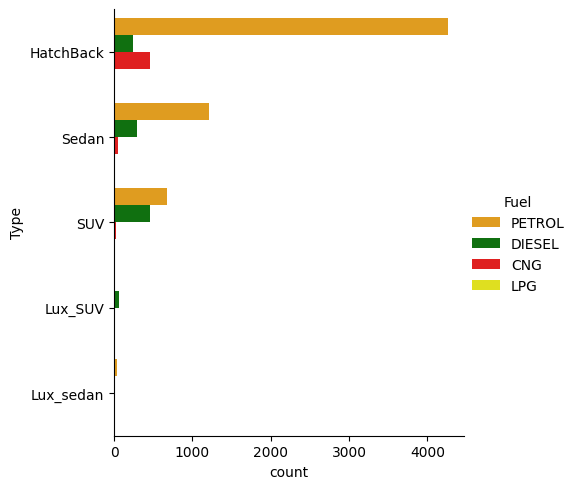

In [ ]:
#define a palette of categories
palette = {
    'PETROL': 'orange',
    'DIESEL': 'green',
    'LPG':'yellow',
    'CNG':'red'
}
#plot the cat plot
sns.catplot(

            data=cars_resale, y="Type", hue="Fuel", kind="count",
            palette=palette
)

**Business insight 1. There is greater trend of resale in Hatch Back Petrol fuel vehicle.**

Delete LPG 'Fuel' car entries as there are very least number of entries present in it that can't even be visualize. Also, PETROL & CNG 'Fuel' Lux_SUV 'Type' car entries and DIESEL & CNG 'Fuel' Lux_sedan 'Type' have very minimal entries that might decrease prediction accuracy of model.

In [8]:
#delete LPG from 'Fuel' column
cars_resale = cars_resale[cars_resale["Fuel"] != "LPG"]

#remove PETROL and CNG from 'Fuel Type' where 'Type' is 'Lux_SUV'
cars_resale = cars_resale[~((cars_resale["Type"] == "Lux_SUV") & (cars_resale["Fuel"].isin(["PETROL", "CNG"])))]

#remove DIESEL and CNG from 'Fuel Type' where 'Type' is 'Lux_sedan'
cars_resale = cars_resale[~((cars_resale["Type"] == "Lux_sedan") & (cars_resale["Fuel"].isin(["DIESEL", "CNG"])))]

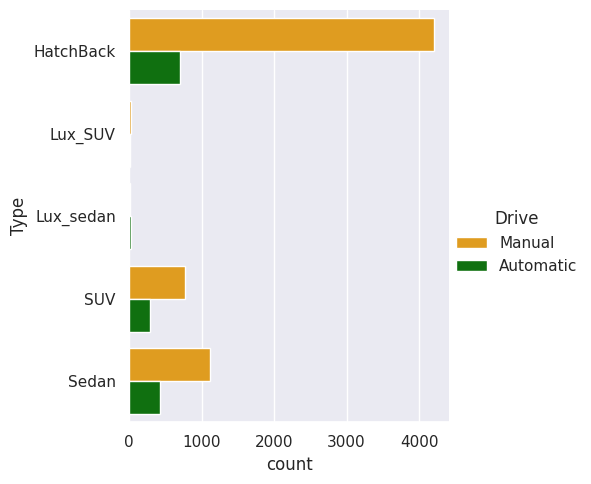

In [ ]:
#define a palette of categories
palette = {
    'Manual': 'orange',
    'Automatic': 'green',
    'SEMI-AUTOMATIC': 'red'
}

#plot the cat plot
sns.catplot(

            data=cars_resale, y="Type", hue="Drive", kind="count",
            palette=palette
)

**Business insight 2. There is greater trend in resale of Manual transmission drive cars of Hatch back segment.**

Remove SEMI-AUTOMATIC 'Drive' cars entries as there are very minimal number of enries.

In [9]:
#remove SEMI-AUTOMATIC from column 'Drive'
cars_resale = cars_resale[cars_resale["Drive"] != "SEMI-AUTOMATIC"]

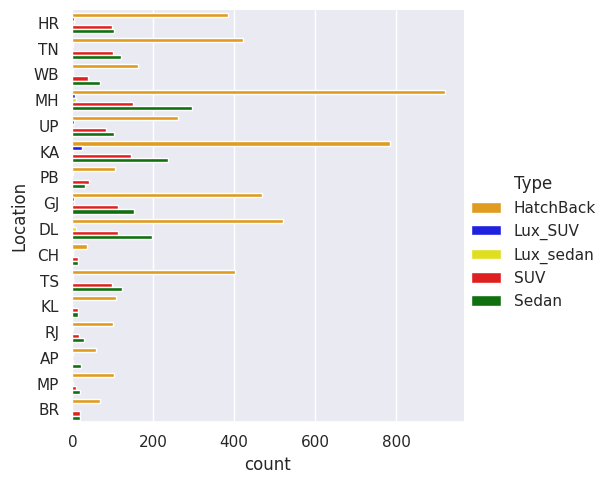

In [ ]:
#define a palette of categories
palette = {
    'HatchBack': 'orange',
    'Sedan': 'green',
    'SUV': 'red',
    'Lux_SUV': 'blue',
    'Lux_sedan': 'yellow'
}

#plot the cat plot

sns.catplot(

            data=cars_resale, y="Location", hue="Type", kind="count",
            palette=palette
)

**Business insight 3: MH(Maharashtra) state has the highest rate of resale cars and most compitetive market but UP(Uttar Pradesh) has highest capability for. development due its larger region but lesser car resale.**

#Feature selection

As categorical feature might be highly corelated with target variable, need to map it to numerical value.

In [10]:
cars_resale["Car Name"] = cars_resale["Car Name"].map({
    'Maruti S PRESSO': 0, 'Hyundai Xcent': 1, 'Maruti Vitara Brezza': 2, 'Tata Tiago': 3,
    'Maruti Swift': 4, 'Renault Kwid': 5, 'Hyundai Grand i10': 6, 'Maruti IGNIS': 7,
    'Honda Brio': 8, 'Hyundai Elite i20': 9, 'Maruti Baleno': 10, 'Honda WR-V': 11,
    'Honda Amaze': 12, 'Maruti Alto 800': 13, 'Maruti Celerio': 14, 'Ford Ecosport': 15,
    'Maruti Ciaz': 16, 'Honda City': 17, 'Datsun Redi Go': 18, 'Hyundai Santro Xing': 19,
    'Ford FREESTYLE': 20, 'Maruti Dzire': 21, 'Maruti Alto': 22, 'Hyundai NEW SANTRO': 23,
    'Maruti Alto K10': 24, 'Maruti Swift Dzire': 25, 'Maruti Wagon R 1.0': 26,
    'Hyundai GRAND I10 NIOS': 27, 'Maruti Celerio X': 28, 'Mahindra XUV500': 29,
    'Hyundai Verna': 30, 'Hyundai VENUE': 31, 'Tata NEXON': 32, 'Mahindra KUV 100 NXT': 33,
    'Toyota YARIS': 34, 'Mahindra XUV 3OO': 35, 'Renault TRIBER': 36, 'Mahindra TUV300': 37,
    'Toyota Glanza': 38, 'Renault Duster': 39, 'Hyundai i10': 40, 'Nissan MAGNITE': 41,
    'KIA SONET': 42, 'Maruti Ertiga': 43, 'Honda Jazz': 44, 'KIA SELTOS': 45,
    'Volkswagen Ameo': 46, 'Renault Kiger': 47, 'Hyundai NEW I20': 48, 'Tata ALTROZ': 49,
    'Maruti Ritz': 50, 'Nissan Micra': 51, 'Hyundai i20': 52, 'Hyundai Eon': 53,
    'Hyundai Creta': 54, 'Toyota Etios Liva': 55, 'Maruti New Wagon-R': 56,
    'Nissan Micra Active': 57, 'Tata PUNCH': 58, 'Volkswagen Polo': 59, 'Toyota Corolla Altis': 60,
    'Honda Civic': 61, 'Volkswagen Vento': 62, 'Maruti S Cross': 63, 'Hyundai i20 Active': 64,
    'Hyundai AURA': 65, 'Tata TIGOR': 66, 'Mahindra Thar': 67, 'Maruti XL6': 68,
    'Skoda Rapid': 69, 'Datsun Go': 70, 'Toyota Etios': 71, 'Mahindra Kuv100': 72,
    'Skoda SLAVIA': 73, 'Hyundai New Elantra': 74, 'Datsun Go Plus': 75
})


cars_resale["Fuel"] = cars_resale["Fuel"].map({
    "PETROL": 0,
    "DIESEL": 1,
    "CNG": 2,
})

cars_resale["Location"] = cars_resale["Location"].map({
    'HR': 0, 'TN': 1, 'WB': 2, 'MH': 3, 'UP': 4, 'KA': 5,
    'PB': 6, 'GJ': 7, 'DL': 8, 'CH': 9, 'TS': 10, 'KL': 11,
    'RJ': 12, 'AP': 13, 'MP': 14, 'BR': 15
})

cars_resale["Drive"] = cars_resale["Drive"].map({
    'Manual': 0,
    'Automatic': 1
})

cars_resale["Type"] = cars_resale["Type"].map({
    'HatchBack': 0,
    'Sedan': 1,
    'SUV': 2,
    'Lux_SUV': 3,
    'Lux_sedan': 4
})



<function matplotlib.pyplot.show(close=None, block=None)>

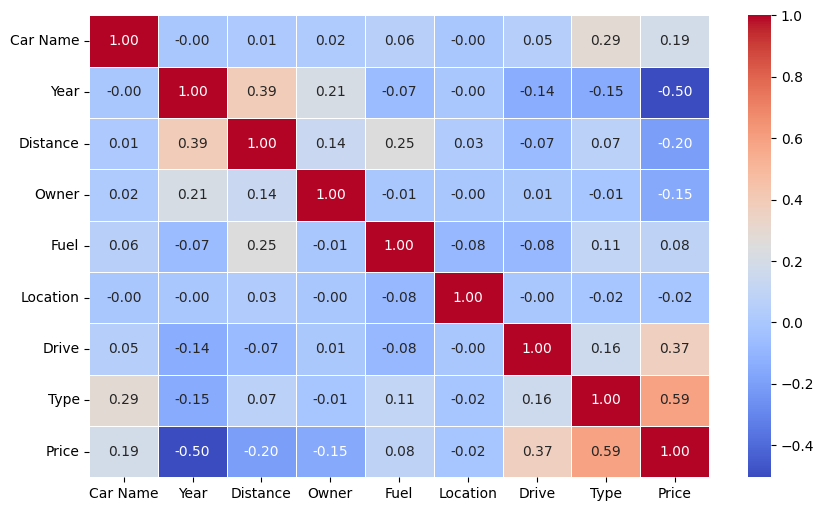

In [ ]:
#corelation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cars_resale.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show


Type has highest correlation (positive) with Target variable Price but still as this is ~.6 we need all other variables as it seems the correlation is distributed across.

#Modelling

In [11]:
#assign X & y variables
X = cars_resale.drop(columns=['Price'])
y = cars_resale['Price']
X['Type'] = X['Type'].astype(int)
#split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

#assign Random forest Regressor as the predictive model

predictive_model = XGBRegressor()

#train the model on the training dataset
predictive_model.fit(X_train, y_train)

#predictions on the test dataset
y_pred = predictive_model.predict(X_test)


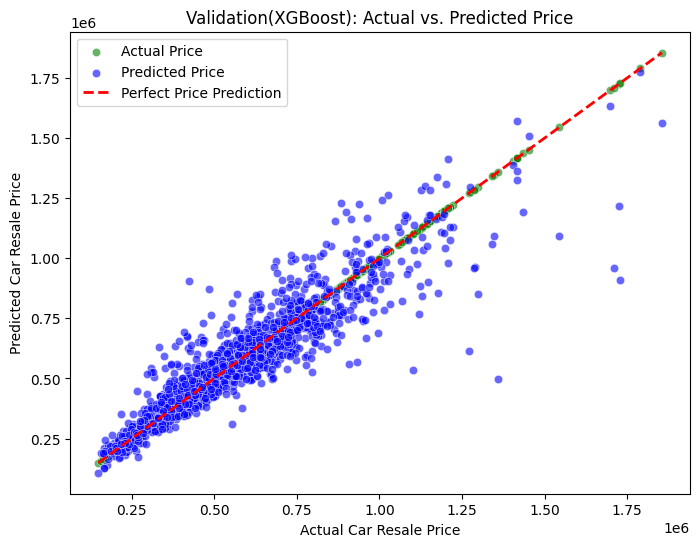

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_test, color='green', alpha=0.6, label='Actual Price')
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.6, label='Predicted Price')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', linewidth=2, label="Perfect Price Prediction")
plt.xlabel("Actual Car Resale Price")
plt.ylabel("Predicted Car Resale Price")
plt.title("Validation(XGBoost): Actual vs. Predicted Price")
plt.legend()
plt.show()

In [15]:
#evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: ", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared score: ", r2)

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: ", mse)

rmse = np.sqrt(mse)
print("Root mean squared error: ", rmse)

Mean Absolute Error:  60631.31640625
R-squared score:  0.838396430015564
Mean squared error:  9372748800.0
Root mean squared error:  96812.95781040883


Mean Absolute Error (MAE): The model predicts car prices with an average error of 58,168, which is relatively low as car prices in the dataset are high (Min- 100000 - Max- 3000000)

R-squared (R²): The model explains 83.3% of the variance in car prices, indicating prediction power of the features (X).

In [ ]:
pip install streamlit

In [ ]:
import joblib
joblib.dump(predictive_model,"cars_resale_model")

data = pd.DataFrame({"Car Name":0.0 ,"Year":2.0 ,"Distance":3878 ,"Owner":1 ,"Fuel":0 ,"Location":0 ,"Drive":0 ,"Type":2}, index=[0])
new_prediction = predictive_model.predict(data)
print(" The prediction value : Rs.",new_prediction)

 The prediction value : Rs. [819053.56]


In [ ]:
cars_resale.head()

Car Name  Year  Distance  Owner  Fuel  Location  Drive Type   Price
0       0.0   2.0      3878      1     0         0      0    0  514000
1       1.0   6.0     32041      1     0         1      0    1  674000
3       2.0   5.0     51718      1     1         2      0    2  690000
4       3.0   3.0     19811      1     0         0      0    0  526000
5       4.0   7.0     70129      1     0         3      0    0  552000